In [1]:
#Load libraries 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import sspa
from sklearn.preprocessing import StandardScaler
import scipy 
import networkx as nx


In [ ]:
#Load the whole dataset
#df = pd.read_csv('Data/Su_COVID_metabolomics_processed.csv', index_col=0)
#df.index= df.index.str.rstrip('-BL')
#print(df.iloc[:10,-2:])    #show subset of control data (first 10 rows, last two columns)

In [2]:
#Load the common cases dataset
df = pd.read_csv('Data/Su_COVID_metabolomics_processed_commoncases.csv', index_col=0)

In [3]:
#This function takes in dataframe, and masks one half and the diagonal to remove duplicates to prepare for a histogram plot
def duplicate_removal(df):
    #Mask the upper half of the dataframe (so I don't view the comparisons between the two same genes, and also the duplicate comparisons are removed)
    mask =  df.copy()
    mask = np.triu(np.ones(mask.shape)).astype(bool)
    mask = np.invert(mask) #invert true and false values so the diagonal is False as well
    non_dup_df = pd.DataFrame(df)
    non_dup_df = non_dup_df.where(mask) #Replace all false values with NaN using mask

    spearman_hist = non_dup_df.to_numpy().flatten()
    spearman_hist = spearman_hist[~np.isnan(spearman_hist)] #remove nan values

    return spearman_hist

### FOR DATA INTEGRATION STEP OR IF COMPARING BY CASE SEVERITY
### Subset the data to common samples

We make two different networks, one for the COVID cases 1-2 compared to COVID cases 3-7 <br>
This is because there are only 18 samples in common between the metabolomic and proteomic datasets

0       Common samples: 18           Metabolomic samples: 133        Proteomic samples: 123 <br>
1-2       Common samples: 45          Metabolomic samples: 45        Proteomic samples: 48 <br>
3-4       Common samples: 56          Metabolomic samples: 57        Proteomic samples: 59 <br>
5-7       Common samples: 27          Metabolomic samples: 28        Proteomic samples: 28 <br>

146 common samples overall,   128 cases, composed of (45 samples (WHO 1-2) vs 83 samples (WHO 3-7))

Subsetting the dataset to common samples and THEN CENTERING THE DATA ONCE MORE (no need to log2 transform):

In [ ]:
#df2 = pd.read_csv('Data/Su_COVID_proteomics_processed.csv', index_col=0)
#list1 = list(df.index)
#list2 = list(df2.index)

#Obtain common samples and subset accordingly
#intersection = list(set(df.index.tolist()) & set(df2.index.tolist())) #set removes duplicates
#intersection = [sample for sample in intersection if sample.startswith("INCOV")]
#df = df[df.index.isin(intersection)]

#print(len(df))
#df_num  = df.iloc[:,:-2] #all rows, all columns apart from last two
#df_norm = pd.DataFrame(StandardScaler().fit_transform(df_num),columns=df_num.columns, index=df_num.index)

#Add metadata to the end of the df
#df_final = pd.concat([df_norm, df.iloc[:,-2:]],axis=1) 
#df_final.to_csv('Data/Su_COVID_metabolomics_processed_commoncases.csv')

Subsetting the dataframe into two groups:

In [4]:
df_mild = (df[df["WHO_status"] == '1-2']) #45 samples, no need to remove the metadata, since I do that in a later step
df_severe = (df[(df["WHO_status"] == '3-4') | (df["WHO_status"] == '5-7')]) #83 samples

### Data exploration

In [ ]:
print("Number of metabolites:", len(df. columns[:-2]) )
print("Number of samples:", len(df. index))

print(df['WHO_status'].value_counts()) 
print(df['Group'].value_counts())

#return non-integer columns
df.dtypes[df.dtypes != 'int64'][df.dtypes != 'float64']

In [ ]:
#Check data is standardised 

df_num  = df.iloc[:,:-2] #all rows, all columns apart from last two
print(df_num.max().max())
print(df_num.min().min())
print(df_num.mean(axis = 0)) #mean of 0
print(df_num.std(axis = 0)) #sd of 1


In [ ]:
df_hist = df_num.mean(axis = 0) #axis = 0 by column
sns.histplot(df_hist, bins = 30,color='#79C99E',edgecolor="k") 

#The mean value for each metabolite has been plotted
plt.title('Mean metabolite distribution',fontsize=16)
plt.xlabel('Metabolite expression (e-15)',fontsize=13)
plt.ylabel('Count',fontsize=13) ;

#plt.savefig( 'Figures/mean_metabolite_distribution.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
df_num = df_num.to_numpy()

df_hist = df_num.flatten()
sns.histplot(df_hist, bins = 30,color='#79C99E',edgecolor="k") 

plt.title('Metabolite distribution',fontsize=16)
plt.xlabel('Metabolite expression',fontsize=13)
plt.ylabel('Count',fontsize=13) ;

#plt.savefig( 'Figures/metabolite_distribution.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#print(df.iloc[:,-5:])
df_heatmap = df.groupby('WHO_status').mean(numeric_only=True)
#print(df_heatmap.iloc[:,-5:])

g = sns.clustermap(
    df_heatmap,
    metric='euclidean', 
    method ="ward",
    row_cluster=False,
    xticklabels=False,
    cmap='RdBu_r',
    figsize=(9,3),
    dendrogram_ratio=0.2, 
    vmin=-2, 
    vmax=2) 

g2 = g.ax_heatmap
g2.set_xlabel("Metabolites", fontsize = 15,labelpad=10) #labelpad increases the distance between the axis label and the heatmap
g2.set_ylabel("WHO status", fontsize = 15, labelpad=12) 
g2.set_yticklabels(g2.get_yticklabels(), rotation=0, fontsize=10)  #rotate the y-axis labels so that they are horizontal

x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([1.15, 0.28, 0.03, 0.35])
g.cax.set_title("Metabolite expression",pad=10, size=13) #pad: increase spacing slightly  
g.cax.tick_params(labelsize=10) #change font size of colourbar labels; 

#plt.savefig( 'Figures/metabolite_heatmap.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Carry out PCA

#from sklearn.decomposition import PCA

features = df.columns[:-2]
x = df.loc[:, features].values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#Restore original index
df2 = df2.set_index(df.index)

#Concatenate WHO information
df3 = pd.concat([df2, df[['WHO_status']]], axis = 1)

display(df3)



sns.set_style("white")


sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=df3, 
    hue='WHO_status', 
    hue_order = ['0', '1-2', '3-4','5-7'],
    fit_reg=False, #don't draw line of best fit
    legend=False,
    scatter_kws={"s": 20}
    )
#Note: I don't use the seaborn legend but check it matches with the seaborn legend


plt.title('PCA for metabolites',fontsize=20)
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)',fontsize=15,)
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)',fontsize=15)
plt.legend(framealpha=1, frameon = 'True', title="WHO status",title_fontsize='large', prop={'size': 14}, bbox_to_anchor=(1.04, 0.7)) 
#This has more information on the bbox_to_anchor coordinates: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot

#plt.savefig( 'Figures/metabolite_PCA.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


### Single sample pathway analysis

In [9]:
#Trying to download latest version of Reactome (version 84)


#reactome_pathways = sspa.process_reactome("Homo sapiens", download_latest=True, filepath=".")
reactome_pathways = sspa.process_gmt("Data/Reactome_Homo_sapiens_pathways_compounds_R84.gmt")
#View name of pathway IDs
reactome_pathways

kpca_scores = sspa.sspa_kpca(df.iloc[:,:-2], reactome_pathways)
#We have 160 pathways present, although the previous report had 165 pathways

#print(kpca_scores.iloc[-10:,-2:])
#print(kpca_scores)
#won't work with the metabolite dataset with names
kpca_scores

,R-HSA-110331,R-HSA-112310,R-HSA-112311,R-HSA-112315,R-HSA-112316,R-HSA-1237112,R-HSA-1266738,R-HSA-1368082,R-HSA-1368108,R-HSA-1428517,...,R-HSA-9709957,R-HSA-9711123,R-HSA-9717189,R-HSA-9717207,R-HSA-9734207,R-HSA-9735804,R-HSA-9748784,R-HSA-9749641,R-HSA-9753281,R-HSA-975634
sample_id,,,,,,,,,,,,,,,,,,,,,
INCOV001,0.659201,0.225778,-0.333568,0.131918,0.131918,-0.187713,-0.156131,-0.156131,-0.156131,-0.117380,...,0.024685,-0.156131,0.198990,0.391366,-0.399308,0.276791,0.369975,-0.393689,-0.269089,-0.156131
INCOV002,-0.235025,0.107705,-0.055220,0.001349,0.001349,0.480965,-0.656364,-0.656364,-0.656364,0.466432,...,0.291172,-0.656364,0.257081,0.344882,-0.082913,0.151529,-0.031173,0.684900,-0.263706,-0.656364
INCOV003,-0.389295,0.493261,-0.559115,0.546906,0.546906,0.359137,-0.464955,-0.464955,-0.464955,0.429492,...,0.322813,-0.464955,0.336509,-0.233873,0.522441,-0.369550,-0.188792,0.477010,-0.414086,-0.464955
INCOV004,-0.327123,0.128953,0.507124,-0.067864,-0.067864,0.227053,-0.532466,-0.532466,-0.532466,0.154896,...,0.318768,-0.532466,0.411548,0.517398,-0.387860,0.635311,0.454831,-0.159320,-0.073333,-0.532466
INCOV005,-0.306598,0.080210,0.639908,-0.035779,-0.035779,0.262356,-0.486363,-0.486363,-0.486363,0.177872,...,0.140315,-0.486363,-0.068573,-0.210360,-0.258794,0.450762,0.057056,0.063811,-0.195554,-0.486363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV133,-0.099730,-0.163202,-0.349911,-0.053659,-0.053659,0.591906,0.652896,0.652896,0.652896,-0.279422,...,0.013464,0.652896,0.191931,0.436753,0.530201,-0.408262,-0.117046,-0.294711,-0.470379,0.652896
INCOV136,-0.464712,0.113496,-0.190195,0.162239,0.162239,0.605763,0.587251,0.587251,0.587251,-0.588061,...,-0.460039,0.587251,-0.446816,-0.337038,0.487556,-0.387735,0.326789,-0.456267,-0.472183,0.587251
INCOV137,0.149842,0.281230,-0.299854,0.222138,0.222138,0.307793,-0.620091,-0.620091,-0.620091,0.478376,...,0.297221,-0.620091,0.257532,0.345060,0.091011,-0.175765,0.406242,-0.147893,-0.423819,-0.620091


In [10]:
#Remove root pathways
#Convert pathway ID to name
root_path = pd.read_excel('Data/Root_pathways.xlsx', header=None)
root_pathway_dict = {root_path[0][i]:root_path[1][i] for i in range(0,len(root_path))}

root_pathway_names = list(root_pathway_dict.keys())
#Using Sara's code
kpca_scores = kpca_scores.drop(columns = list(set(root_pathway_names) & set(kpca_scores.columns)))

In [ ]:
kpca_scores

### kPCA figures

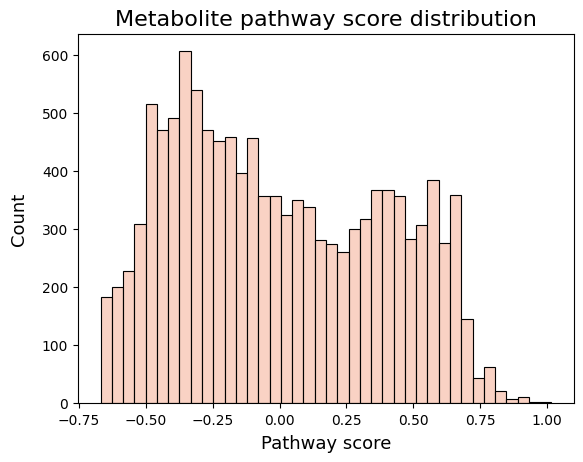

In [11]:

kpca_hist = kpca_scores.to_numpy()
kpca_hist = kpca_hist.flatten()
sns.histplot(kpca_hist, bins = 40,color='#F7C3B1',edgecolor="k") 

plt.title('Metabolite pathway score distribution',fontsize=16)
plt.xlabel('Pathway score',fontsize=13, labelpad=5)
plt.ylabel('Count',fontsize=13, labelpad=10) ;

#plt.savefig( 'Figures/metabolite_pathway_distribution.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

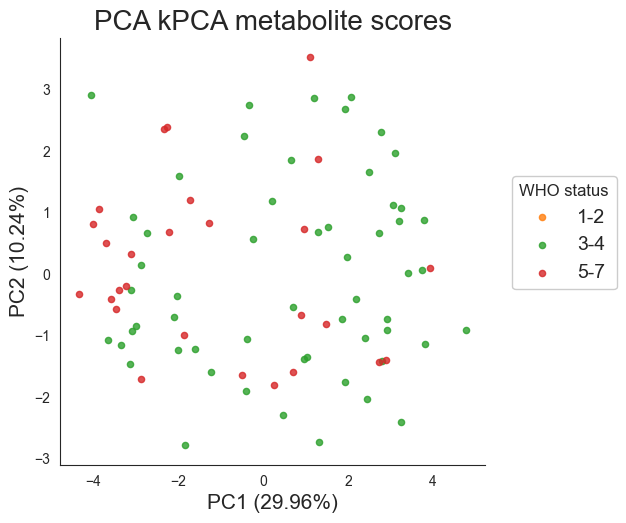

In [13]:
#Carry out PCA

#from sklearn.decomposition import PCA

features = kpca_scores.columns
x = kpca_scores.loc[:, features].values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#Restore original index
df2 = df2.set_index(df.index)

#Concatenate WHO information
df3 = pd.concat([df2, df[['WHO_status']]], axis = 1)

#display(df3)


sns.set_style("white")


sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=df3, 
    hue='WHO_status', 
    hue_order = ['0', '1-2', '3-4','5-7'],
    fit_reg=False, 
    legend=False,
    scatter_kws={"s": 20}
    )
#Note: I don't use the seaborn legend but check it matches with the seaborn legend


plt.title('PCA kPCA metabolite scores',fontsize=20)
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)',fontsize=15)
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)',fontsize=15)
plt.legend(framealpha=1, frameon = 'True', title="WHO status",title_fontsize='large', prop={'size': 14}, bbox_to_anchor=(1.04, 0.7))
#This has more information on the bbox_to_anchor coordinates: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
#plt.savefig( 'Figures/metabolite_kPCA_PCA.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


In [ ]:
#Normalise pathway scores : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

#StandardScaler() normalises by column i.e. each pathway is normalised across all patients
#mean of the observed values becomes 0 and the standard deviation is 1

#After meeting: Normalising doesn't seem to have a large effect
#Whether or not you normalise won't make a huge difference
kpca_scores_norm = pd.DataFrame(StandardScaler().fit_transform(kpca_scores),columns=kpca_scores.columns, index=kpca_scores.index)

#print(kpca_scores_norm.max().max())
#print(kpca_scores_norm.min().min())
#print(kpca_scores_norm.mean(axis = 0)) #mean of 0  
#print(kpca_scores_norm.std(axis = 0)) #sd of 1



kpca_hist = kpca_scores_norm.to_numpy()
kpca_hist = kpca_hist.flatten()
sns.histplot(kpca_hist, bins = 40,color='#F7C3B1',edgecolor="k") 

plt.title('Normalised metabolite pathway score distribution',fontsize=16)
plt.xlabel('Pathway score',fontsize=13, labelpad=5)
plt.ylabel('Count',fontsize=13, labelpad=10) ;

#plt.savefig( 'Figures/normalised_metabolite_pathway_distribution.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Carry out PCA on NORMALISED values

#from sklearn.decomposition import PCA

features = kpca_scores_norm.columns
x = kpca_scores_norm.loc[:, features].values

pca = PCA(n_components=2)
principal_components = pca.fit_transform(x)
df2 = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

#Restore original index
df2 = df2.set_index(df.index)

#Concatenate WHO information
df3 = pd.concat([df2, df[['WHO_status']]], axis = 1)

#display(df3)


sns.set_style("white")


sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=df3, 
    hue='WHO_status', 
    hue_order = ['0', '1-2', '3-4','5-7'],
    fit_reg=False, 
    legend=False,
    scatter_kws={"s": 20}
    )
#Note: I don't use the seaborn legend but check it matches with the seaborn legend


plt.title('PCA kPCA normalised metabolite scores',fontsize=20)
plt.xlabel('PC1 (' + str(round(pca.explained_variance_ratio_[0]*100,2)) + '%)',fontsize=15)
plt.ylabel('PC2 (' + str(round(pca.explained_variance_ratio_[1]*100,2)) + '%)',fontsize=15)
plt.legend(framealpha=1, frameon = 'True', title="WHO status",title_fontsize='large', prop={'size': 14}, bbox_to_anchor=(1.04, 0.7))
#This has more information on the bbox_to_anchor coordinates: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
#plt.savefig( 'Figures/normalised_metabolite_kPCA_PCA.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')



### Spearman correlation coefficient

In [ ]:
kpca_scores

In [14]:
#Note: Spearman correlation coefficient results are the same whether or not the kPCA scores are normalised

#"If axis=0 (default), then each column represents a variable, with observations in the rows"
spearman_results = scipy.stats.spearmanr(kpca_scores)

spearman_coef = spearman_results[0] #correlation coefficients
spearman_pvals = spearman_results[1] #p-values


#Using Sara's code (rather than having separate dataframes for each analysis, add all together in long format)
squared_spearman_coef_df = pd.DataFrame(spearman_coef,columns = kpca_scores.columns, index=kpca_scores.columns)
squared_spearman_coef_list = squared_spearman_coef_df.stack().reset_index()
squared_spearman_coef_list.columns = ["Pathway1", "Pathway2", "Spearman_corr"]
squared_spearman_coef_list["Squared_corr"]  = np.square(squared_spearman_coef_list.Spearman_corr)

spearman_pvals_df = pd.DataFrame(spearman_pvals,columns = kpca_scores.columns, index=kpca_scores.columns)
spearman_pvals_list = spearman_pvals_df.stack().reset_index()
spearman_pvals_list.columns = ["Pathway1", "Pathway2", "pval"]

#Multiple testing correction for the p-values to prepare the corrected p-values for the final correlation network
#Multiplies by the correct number of tests (i.e. not including the duplicates or self-comparisons)
#Does not remove the diagonals or the duplicates themselves
#  ((160x160)-160)  / 2
num_of_tests = (len(kpca_scores.columns)**2 - len(kpca_scores.columns))/2
print(num_of_tests)
corrected_spearman_pvals = spearman_pvals_list.pval*num_of_tests
#If the p-val goes beyond 1 (max number for a p-value, change to 1)
corrected_spearman_pvals = np.where(corrected_spearman_pvals < 1, corrected_spearman_pvals, 1)
spearman_pvals_list["pval_adj"]  = corrected_spearman_pvals

spearman_df = squared_spearman_coef_list.merge(spearman_pvals_list,on=["Pathway1","Pathway2"])

display(spearman_df)

10296.0


,Pathway1,Pathway2,Spearman_corr,Squared_corr,pval,pval_adj
0,R-HSA-110331,R-HSA-110331,1.000000,1.000000,0.000000e+00,0.000000e+00
1,R-HSA-110331,R-HSA-112310,0.083981,0.007053,4.503506e-01,1.000000e+00
2,R-HSA-110331,R-HSA-112311,-0.169367,0.028685,1.258458e-01,1.000000e+00
3,R-HSA-110331,R-HSA-112315,0.103102,0.010630,3.536481e-01,1.000000e+00
4,R-HSA-110331,R-HSA-1237112,-0.686579,0.471391,7.779217e-13,8.009482e-09
...,...,...,...,...,...,...
20731,R-HSA-975634,R-HSA-9734207,-0.035935,0.001291,7.470590e-01,1.000000e+00
20732,R-HSA-975634,R-HSA-9735804,0.063977,0.004093,5.655555e-01,1.000000e+00
20733,R-HSA-975634,R-HSA-9749641,0.064292,0.004133,5.636402e-01,1.000000e+00
20734,R-HSA-975634,R-HSA-9753281,-0.121552,0.014775,2.736631e-01,1.000000e+00


Bonferroni: https://avast.github.io/ep-stats/stats/multiple.html

Method 1: The alpha value (0.05) is divided by the number of tests (e.g. 225 pathways x 225 pathways = 50,625) and then the original p-vals are compared to the adjusted alpha value

Method 2: The alpha value remains unchanged and the individual p-values are adjusted (i.e. original p-value x number of tests) to increase them, and then compared to see if they cross the 0.05 significance level

After adjustment, some corrected p-values go up to 1 (the maximum)

In [15]:
#Perform multiple testing correlation on p-values after the duplicates are removed

#All self-comparisons are significant with a p-value of 0, so we can subtract those from the number of significant values before we divide by 2
sig_vals = (sum(i < 0.005 for i in spearman_df.pval_adj)-len(kpca_scores.columns))   /2
non_sig_vals = sum(i >= 0.005 for i in spearman_df.pval_adj)/2

print("Number of significant values:", sig_vals)
print("Number of non-significant values:", non_sig_vals)
(sig_vals/(sig_vals+non_sig_vals)) * 100

Number of significant values: 1198.0
Number of non-significant values: 9098.0


11.635586635586636

10296


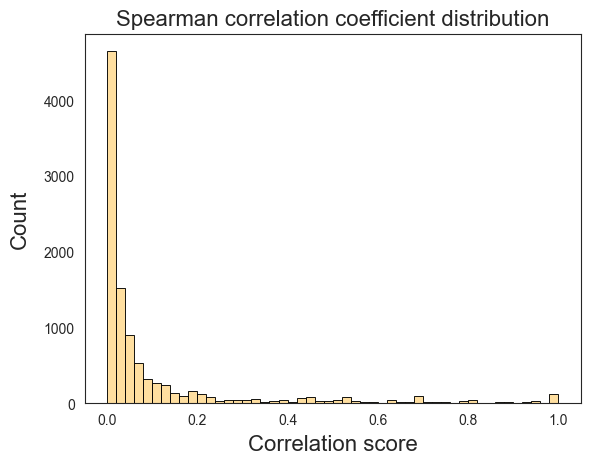

In [16]:
squared_spearman_coef = np.square(spearman_coef)
abs_spearman_coef = np.abs(spearman_coef)
spearman_hist = duplicate_removal(squared_spearman_coef)  #using a function I defined in the intro section

print(len(spearman_hist))
sns.histplot(spearman_hist, bins = 50,color='#FFD580',edgecolor="k") 

plt.title('Spearman correlation coefficient distribution',fontsize=16)
plt.xlabel('Correlation score',fontsize=16, labelpad=5)
plt.ylabel('Count',fontsize=16, labelpad=10) ;

#plt.savefig('Figures/metabolite_spearman_correlation_distribution_squared_non_dup.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:

#The reason for plotting as absolute or squared is that kPCA does not determine the directionality of effect
#Therefore the direction specified here is arbitrary i.e. negative pathway score does not mean downregulation of pathway


g = sns.clustermap(
    squared_spearman_coef,
    metric='euclidean', 
    method ="ward",
    cmap="OrRd",    #Spectral_r for normal,  OrRd for the other two
    xticklabels=False,
    yticklabels=False,
    figsize=(6,6),
    dendrogram_ratio=0.15, 
    vmin=0, 
    vmax=1) 

g2 = g.ax_heatmap
g2.set_xlabel("Pathways", fontsize = 17, labelpad=10) #labelpad increases the distance between the axis label and the heatmap
g2.set_ylabel("Pathways", fontsize = 17, labelpad=10) 

x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([1.1, 0.25, 0.03, 0.35])
g.cax.set_title("Correlation score",pad=13,size=13) #pad: increase spacing slightly  
g.cax.tick_params(labelsize=12) #change font size of colourbar labels; 

#plt.savefig( 'Figures/squared_metabolite_spearman.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Plotting the Spearman p-values
np.seterr(divide = 'ignore')    
log_spearman_pvals = -np.log10(spearman_pvals)
np.seterr(divide = 'warn') 

spearman_pval_hist = duplicate_removal(log_spearman_pvals)  #Some inf values that are not plotted (too far along axis)
print(len(spearman_pval_hist))
sns.histplot(spearman_pval_hist, bins = 50,color='#FFD580',edgecolor="k") 

plt.title('Spearman p-value distribution',fontsize=16)
plt.xlabel('Spearman p-values (-log10)',fontsize=16, labelpad=5)
plt.ylabel('Count',fontsize=16, labelpad=10) ;

#plt.savefig('Figures/metabolite_spearman_pval_distribution_non_dup.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

### Overlap coefficients

I believe that sspa kPCA automatically filters out all pathways that have less than 2 compounds in them (confirmed since the pathway with the minimum number of metabolites had 2 compounds). When I filter out the compounds that are not in the dataset, I only include them into the new dictionary if the values have more than 1 compound.

In [17]:
#Obtain pathways and corresponding metabolites for all Reactome pathways, store as dictionary
orig_dict = sspa.utils.pathwaydf_to_dict(reactome_pathways)

#Filter out dictionary to retain only the pathways that remain after kPCA
my_keys = kpca_scores.columns
pathways_dict = {key: orig_dict[key] for key in my_keys}


In [18]:
#Filter out the compounds in the pathways that are not present in the dataset

#Obtain all unique values in dataset
compounds_present = list(df.columns[:-2])
filtered_dict = {} 

#My code adapted from Cecilia's
#If the key values are not part of the compounds in dataset then remove
for key,value in pathways_dict.items():
    new_val = [item for item in value if item in compounds_present]
    if len(new_val) >= 2: #at least two compounds in the pathway
        filtered_dict[key] = new_val



In [19]:
#Identifying all duplicate pathways from the Reactome pathway dictionary AFTER COMPOUNDS NOT IN PATHWAY REMOVED (the exact same metabolites, not subsets)

metabolites = list(filtered_dict.values())

from collections import Counter

c = Counter(map(tuple,metabolites))
dups = [k for k,v in c.items() if v>1]
result = [list(t) for t in dups]

for j in result:
    value = {i for i in filtered_dict if filtered_dict[i]==j}
    print(value)
    

{'R-HSA-110331', 'R-HSA-73927'}
{'R-HSA-2426168', 'R-HSA-381340', 'R-HSA-2151201', 'R-HSA-1592230', 'R-HSA-1368082', 'R-HSA-1368108', 'R-HSA-1655829'}
{'R-HSA-1428517', 'R-HSA-71406'}
{'R-HSA-159418', 'R-HSA-193368'}
{'R-HSA-400451', 'R-HSA-163685', 'R-HSA-422356'}
{'R-HSA-194068', 'R-HSA-192105'}
{'R-HSA-400206', 'R-HSA-1989781'}
{'R-HSA-2161522', 'R-HSA-2161541', 'R-HSA-5683826'}
{'R-HSA-9707616', 'R-HSA-975634', 'R-HSA-9711123', 'R-HSA-2453902', 'R-HSA-9707564', 'R-HSA-2187338'}
{'R-HSA-2408522', 'R-HSA-2408508'}
{'R-HSA-444209', 'R-HSA-2980736', 'R-HSA-381771', 'R-HSA-400508'}
{'R-HSA-388396', 'R-HSA-372790'}
{'R-HSA-434316', 'R-HSA-400511'}
{'R-HSA-445717', 'R-HSA-432047'}
{'R-HSA-433692', 'R-HSA-5619070'}
{'R-HSA-888590', 'R-HSA-442660'}
{'R-HSA-804914', 'R-HSA-5619108'}
{'R-HSA-6782861', 'R-HSA-6782315', 'R-HSA-72312', 'R-HSA-72306'}
{'R-HSA-70171', 'R-HSA-70326'}
{'R-HSA-73884', 'R-HSA-73929'}
{'R-HSA-77108', 'R-HSA-77111'}


In [ ]:
#Find the pathways with the minimum and maximum number of metabolites in pathways AFTER COMPOUNDS NOT IN PATHWAY REMOVED

max_len = max(metabolites, key=len)
print(len(max_len))

min_len = min(metabolites, key=len)
print(len(min_len))


for index in range(0,len(metabolites)):
    length = 33
    value = {key for key in filtered_dict if len(filtered_dict[key])==length}
print(value)

#len(filtered_dict['R-HSA-1430728'])

In [ ]:
#Checking Overlap coefficient code for the cell below

list1 = ['A','B','C','D','E','F','G']
list2 = ['A','B','C','J','K','L','M','N']
intersection = list(set(list1).intersection(list(set(list2))))  #set removes duplicates
numerator = len(intersection)

smaller_set = []
smaller_set.append(len(list1))
smaller_set.append(len(list2))
denominator = min(smaller_set)

val = (numerator/denominator)
print(val)

In [20]:
#Difference between Jaccard similarity metric and S-S Overlap Coefficient
#https://developer.nvidia.com/blog/similarity-in-graphs-jaccard-versus-the-overlap-coefficient/

#Using Overlap Coefficient formula 
#My original code is in 'Overlap_coefficient_ver83.ipynb'
#I adapted by code by looking at Cecilia's comments
oc_matrix = np.zeros((len(my_keys),len(my_keys)))    

for i in range(0,len(my_keys)):   
    list1 = filtered_dict[my_keys[i]]
    
    for j in range(0,len(my_keys)):
        list2 = filtered_dict[my_keys[j]]

        # Szymkiewicz–Simpson coefficient
        #Find intersection between two lists
        intersection = len(list(set(list1).intersection(list(set(list2)))))
        smaller_set = min(len(list1), len(list2))

        val = intersection/smaller_set
        oc_matrix[i][j] = val 
        

In [21]:
oc_df = pd.DataFrame(oc_matrix, index=filtered_dict.keys(), columns=filtered_dict.keys())
#Calculate number of edges with values above or equal to 0.5

#If looking at whole matrix (not accounting for self comparisons or duplicates)
#print(np.count_nonzero(oc_matrix >= 0.5)/(len(my_keys)*len(my_keys)))

#Subtract by number of self-comparisons divided by 2
high_overlap = (np.count_nonzero(oc_matrix >= 0.5) - len(my_keys)) / 2
unique_edges =  ((len(my_keys)*len(my_keys)) - len(my_keys)) / 2

print(high_overlap  /  unique_edges) 


0.18822843822843824


In [22]:
oc_list = oc_df.stack().reset_index()
oc_list.columns = ["Pathway1", "Pathway2", "Overlap_coef"]
spearman_df = spearman_df.merge(oc_list,on=["Pathway1","Pathway2"])

display(spearman_df)

,Pathway1,Pathway2,Spearman_corr,Squared_corr,pval,pval_adj,Overlap_coef
0,R-HSA-110331,R-HSA-110331,1.000000,1.000000,0.000000e+00,0.000000e+00,1.0
1,R-HSA-110331,R-HSA-112310,0.083981,0.007053,4.503506e-01,1.000000e+00,0.0
2,R-HSA-110331,R-HSA-112311,-0.169367,0.028685,1.258458e-01,1.000000e+00,0.0
3,R-HSA-110331,R-HSA-112315,0.103102,0.010630,3.536481e-01,1.000000e+00,0.0
4,R-HSA-110331,R-HSA-1237112,-0.686579,0.471391,7.779217e-13,8.009482e-09,0.5
...,...,...,...,...,...,...,...
20731,R-HSA-975634,R-HSA-9734207,-0.035935,0.001291,7.470590e-01,1.000000e+00,0.0
20732,R-HSA-975634,R-HSA-9735804,0.063977,0.004093,5.655555e-01,1.000000e+00,0.0
20733,R-HSA-975634,R-HSA-9749641,0.064292,0.004133,5.636402e-01,1.000000e+00,0.0
20734,R-HSA-975634,R-HSA-9753281,-0.121552,0.014775,2.736631e-01,1.000000e+00,0.0


In [ ]:
g = sns.clustermap(oc_matrix,
metric='euclidean', 
method ="ward",
cmap = "OrRd", 
xticklabels=False, 
yticklabels=False, 
figsize=(6,6),
dendrogram_ratio=0.2, 
vmin=-0, 
vmax=1) 

g2 = g.ax_heatmap
g2.set_xlabel("Pathways", fontsize = 17, labelpad=10) #labelpad increases the distance between the axis label and the heatmap
g2.set_ylabel("Pathways", fontsize = 17, labelpad=10) 
g2.set(yticklabels=[])  #remove tick labels
g2.tick_params(right=False) #remove ticks

x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([1.15, 0.25, 0.03, 0.35])
g.cax.set_title("Overlap Coefficient",pad=13,size=13) #pad: increase spacing slightly  
g.cax.tick_params(labelsize=12) #change font size of colourbar labels; 

#plt.savefig( 'Figures/metabolite_overlap_coef.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:
#Plotting the overlap coefficient

oc_hist = duplicate_removal(oc_matrix)
print(len(oc_hist))
sns.histplot(oc_hist, bins = 50,color='#FFD580',edgecolor="k") 

plt.title('Overlap coefficient distribution',fontsize=16)
plt.xlabel('Overlap coefficient',fontsize=16, labelpad=5)
plt.ylabel('Count',fontsize=16, labelpad=10) ;

#plt.savefig('Figures/metabolite_overlap_coef_distribution_non_dup.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [ ]:

f, ax = plt.subplots()
points = ax.scatter(x=oc_hist, y=spearman_pval_hist,c=spearman_hist, s=4, cmap="viridis",alpha=0.3)

cb = plt.colorbar(points, ticks=[0,0.2,0.4,0.6,0.8,1],shrink=0.5)
cb.ax.set_position([0.9, 0.28, 0.03, 0.35])
cb.ax.set_title('Spearman correlation',pad=10, size=10) #pad means the height of title away from colourbar


plt.xlabel("Overlap coefficient",fontsize=13, labelpad=5)
plt.ylabel("Spearman p-values (-l0g10)",fontsize=13, labelpad=10) 

plt.axvline(x=0.5, color='r', linewidth=0.3, linestyle='-')
plt.axhline(y=-np.log10(0.005), color='r', linewidth=0.3, linestyle='-') ;

#plt.savefig('Figures/metabolite_scatterplot.png' ,dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


### Constructing overlap coefficient network graphs

In [ ]:
#Practice code
#Even for an edge going between two pathways, it's a single line here and in Cytoscape as well
#If you wanted to draw multiple edges going between the same two nodes, you would need to draw a multigraph
G = nx.Graph()

practice_df = {'Pathway1': ['A', 'B', 'C', 'D','D'], 'Pathway2': ['B','A','D','C','D'], 'weight': [1,1,2,5,3]}
pd.DataFrame(data=practice_df, index=[0, 1, 2, 3,4])

G = nx.from_pandas_edgelist(df=practice_df, source='Pathway1', target='Pathway2', edge_attr='weight')

nx.draw(G, with_labels = True)

#nx.write_gml(G, "test.gml")

Using Cecilia's code

Note: I don't remove the duplicate edges for the overlap coefficient graph, they seemed to be removed during NetworkX graph construction.
I do remove the diagonals though.

In [23]:
#Remove self-correlations
spearman_df = spearman_df [spearman_df.Pathway1 != spearman_df.Pathway2]
spearman_df = spearman_df.reset_index(drop=True)
spearman_df

,Pathway1,Pathway2,Spearman_corr,Squared_corr,pval,pval_adj,Overlap_coef
0,R-HSA-110331,R-HSA-112310,0.083981,0.007053,4.503506e-01,1.000000e+00,0.0
1,R-HSA-110331,R-HSA-112311,-0.169367,0.028685,1.258458e-01,1.000000e+00,0.0
2,R-HSA-110331,R-HSA-112315,0.103102,0.010630,3.536481e-01,1.000000e+00,0.0
3,R-HSA-110331,R-HSA-1237112,-0.686579,0.471391,7.779217e-13,8.009482e-09,0.5
4,R-HSA-110331,R-HSA-1368082,-0.044184,0.001952,6.916464e-01,1.000000e+00,0.0
...,...,...,...,...,...,...,...
20587,R-HSA-975634,R-HSA-9717207,-0.093825,0.008803,3.988458e-01,1.000000e+00,0.0
20588,R-HSA-975634,R-HSA-9734207,-0.035935,0.001291,7.470590e-01,1.000000e+00,0.0
20589,R-HSA-975634,R-HSA-9735804,0.063977,0.004093,5.655555e-01,1.000000e+00,0.0
20590,R-HSA-975634,R-HSA-9749641,0.064292,0.004133,5.636402e-01,1.000000e+00,0.0


In [ ]:
#I DON'T FILTER OUT ANY EDGES HERE: I FILTER IN CYTOSCAPE

#Add the nodes
G = nx.Graph()
G.add_nodes_from(oc_df.columns)

#does not deal with duplicates i.e.  Pathway 1 to Pathway 2 and vice versa
#but it's ok, because it shows up as one edge on the network in Cytoscape

G = nx.from_pandas_edgelist(df=spearman_df, source='Pathway1', target='Pathway2', edge_attr='Overlap_coef')

nx.draw(G, with_labels = True)
print(G.number_of_edges())
print(G.number_of_nodes())
#nx.write_gml(G, "Cytoscape/metabolomic_oc.gml")

### Final correlation network

Remember to take the corrected Spearman p-values

In [ ]:
spearman_df

#spearman_df.to_csv("Data/metabolomic_edgelist_df_all.csv")
#spearman_df.to_csv("Data/metabolomic_edgelist_df_commoncases.csv")

144
10296


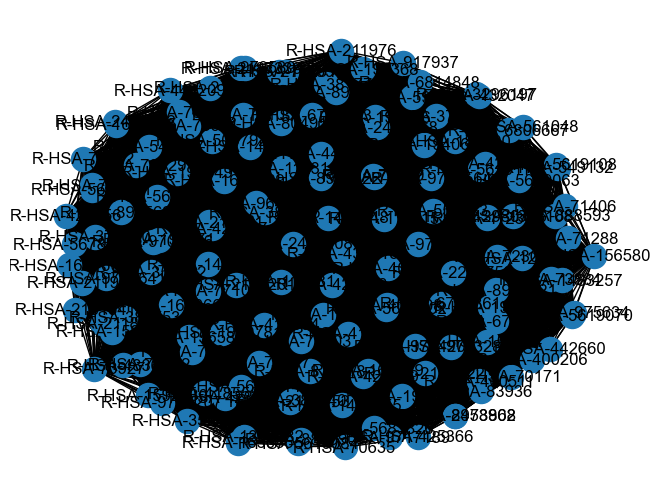

In [24]:
#MAKE A GRAPH WITH ALL THE EDGES FOR THE INTEGRATION STAGE

G = nx.Graph()
G = nx.from_pandas_edgelist(df=spearman_df, source='Pathway1', target='Pathway2', edge_attr='Squared_corr')
#G.add_nodes_from(isolated_nodes)
nx.draw(G, with_labels = True)
print(G.number_of_nodes())
print(G.number_of_edges())


#Add edge attributes
spearman_pval_dict = {}
overlap_coef_dict = {}
for i in range(0,len(spearman_df)):
    spearman_pval_dict[(spearman_df.Pathway1[i],spearman_df.Pathway2[i])] = spearman_df.pval_adj[i]
    overlap_coef_dict[(spearman_df.Pathway1[i],spearman_df.Pathway2[i])] = spearman_df.Overlap_coef[i]


nx.set_edge_attributes(G, spearman_pval_dict, "Spearman_pval")
nx.set_edge_attributes(G, overlap_coef_dict, "Overlap_coef")

G.edges["R-HSA-110331","R-HSA-112310"]#["Spearman_pval"]

#nx.write_gml(G,'Cytoscape/metabolomic_prefiltered_commoncases.gml')
#nx.write_gml(G,'Cytoscape/metabolomic_prefiltered_severecases.gml')


In [25]:
#Create EDGE ATTRIBUTES table to filter out unneeded edges

final_df = spearman_df[spearman_df["pval_adj"] < 0.005]  
final_df = final_df[final_df["Overlap_coef"] < 0.5]
final_df = final_df.reset_index(drop=True) 
display(final_df) #the duplicate edges have not been removed yet

#In some instances, I have nodes which have no edges, and the results are different to Sara's
#Can check the pathways prior to Overlap Coefficient filtering here
#final_df[final_df["Pathway1"] == "R-HSA-196854"]

,Pathway1,Pathway2,Spearman_corr,Squared_corr,pval,pval_adj,Overlap_coef
0,R-HSA-112310,R-HSA-112311,-0.581672,0.338342,8.084231e-09,8.323524e-05,0.333333
1,R-HSA-112310,R-HSA-196854,-0.671550,0.450980,3.685087e-12,3.794166e-08,0.142857
2,R-HSA-112310,R-HSA-1989781,0.661601,0.437716,9.828371e-12,1.011929e-07,0.333333
3,R-HSA-112310,R-HSA-2262752,-0.656710,0.431269,1.570624e-11,1.617114e-07,0.333333
4,R-HSA-112310,R-HSA-400206,0.661601,0.437716,9.828371e-12,1.011929e-07,0.333333
...,...,...,...,...,...,...,...
363,R-HSA-9717189,R-HSA-71387,-0.593405,0.352129,3.381610e-09,3.481705e-05,0.250000
364,R-HSA-9717189,R-HSA-71406,0.629319,0.396042,1.864701e-10,1.919896e-06,0.333333
365,R-HSA-9717189,R-HSA-8978868,-0.671466,0.450867,3.716306e-12,3.826308e-08,0.400000
366,R-HSA-9734207,R-HSA-418594,-0.550921,0.303514,6.790763e-08,6.991769e-04,0.333333


Plot spearman correlation histogram to show edges AFTER filtering

In [26]:
#Remove duplicates in the edge list

final_df_copy = final_df.copy()

#Remove duplicate pathways
for i in range(0,len(final_df)):
    val1 = final_df.Pathway1[i]
    val2 = final_df.Pathway2[i]
    #print(val1,val2)
    #print(max(val1,val2))
    final_df_copy.Pathway1[i] = min(val1,val2)
    final_df_copy.Pathway2[i] = max(val1,val2)

final_df_copy = final_df_copy.sort_values(['Pathway1','Pathway2'], ascending=True)
final_df_copy = final_df_copy[::2]

C:\Users\jenna\AppData\Local\Temp\ipykernel_20872\1514866998.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_copy.Pathway1[i] = min(val1,val2)
C:\Users\jenna\AppData\Local\Temp\ipykernel_20872\1514866998.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_copy.Pathway2[i] = max(val1,val2)


184


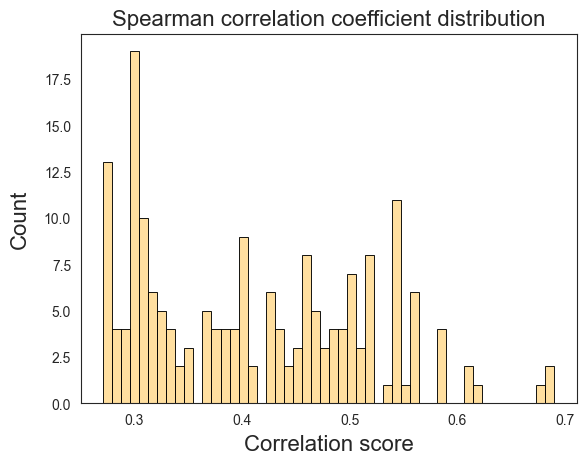

In [27]:
print(len(final_df_copy))
spearman_hist = list(final_df_copy.Squared_corr)
sns.histplot(spearman_hist, bins = 50,color='#FFD580',edgecolor="k") 

plt.title('Spearman correlation coefficient distribution',fontsize=16)
plt.xlabel('Correlation score',fontsize=16, labelpad=5)
plt.ylabel('Count',fontsize=16, labelpad=10) ;

#plt.savefig('Figures/metabolite_spearman_correlation_distribution_squared_afterfiltering_commoncases.png' , dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [28]:
pathways_with_edges = set(final_df.Pathway1)
isolated_nodes = set(spearman_df.Pathway1) - set(pathways_with_edges) 
isolated_nodes
#len(pathways_with_edges)

{'R-HSA-110331',
 'R-HSA-1237112',
 'R-HSA-1368082',
 'R-HSA-1368108',
 'R-HSA-1483148',
 'R-HSA-156580',
 'R-HSA-156584',
 'R-HSA-15869',
 'R-HSA-1592230',
 'R-HSA-159418',
 'R-HSA-1614603',
 'R-HSA-163685',
 'R-HSA-1655829',
 'R-HSA-168249',
 'R-HSA-189200',
 'R-HSA-192105',
 'R-HSA-193368',
 'R-HSA-194068',
 'R-HSA-196071',
 'R-HSA-211859',
 'R-HSA-211897',
 'R-HSA-211945',
 'R-HSA-211957',
 'R-HSA-211976',
 'R-HSA-211981',
 'R-HSA-2142753',
 'R-HSA-2151201',
 'R-HSA-2161522',
 'R-HSA-2161541',
 'R-HSA-2187338',
 'R-HSA-2408508',
 'R-HSA-2408522',
 'R-HSA-2426168',
 'R-HSA-2453902',
 'R-HSA-3296197',
 'R-HSA-351202',
 'R-HSA-352230',
 'R-HSA-381340',
 'R-HSA-400451',
 'R-HSA-400511',
 'R-HSA-418555',
 'R-HSA-420499',
 'R-HSA-422356',
 'R-HSA-425393',
 'R-HSA-428157',
 'R-HSA-433692',
 'R-HSA-434316',
 'R-HSA-442660',
 'R-HSA-549127',
 'R-HSA-549132',
 'R-HSA-561048',
 'R-HSA-5619070',
 'R-HSA-5619071',
 'R-HSA-5619084',
 'R-HSA-5678520',
 'R-HSA-5683826',
 'R-HSA-6798163',
 'R-HSA-7

65
184


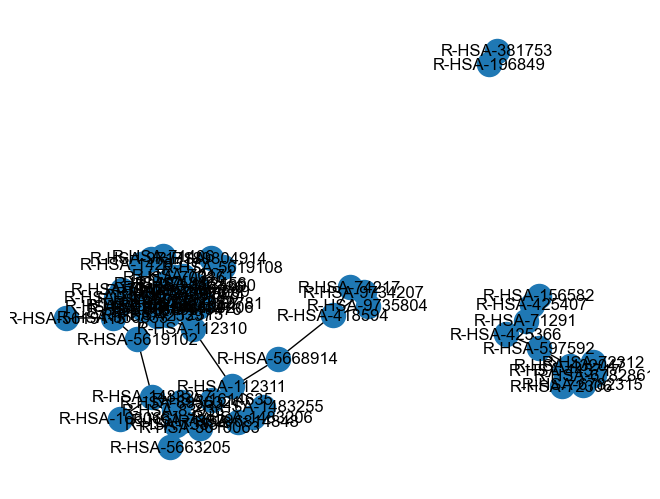

In [29]:
#Draw network graph with new edges
G = nx.Graph()
G = nx.from_pandas_edgelist(df=final_df, source='Pathway1', target='Pathway2', edge_attr='Squared_corr')
#G.add_nodes_from(isolated_nodes)
nx.draw(G, with_labels = True)
print(G.number_of_nodes())
print(G.number_of_edges())

In [30]:

#Add edge attributes
spearman_pval_dict = {}
overlap_coef_dict = {}
for i in range(0,len(final_df)):
    spearman_pval_dict[(final_df.Pathway1[i],final_df.Pathway2[i])] = final_df.pval_adj[i]
    overlap_coef_dict[(final_df.Pathway1[i],final_df.Pathway2[i])] = final_df.Overlap_coef[i]
    
nx.set_edge_attributes(G, spearman_pval_dict, "Spearman_pval")
nx.set_edge_attributes(G, overlap_coef_dict, "Overlap_coef")

#G.edges["R-HSA-110331","R-HSA-112310"]#["Spearman_pval"]



### Optional: Read in the metabolomic network to display the differential network

For the differential network, we aren't trying to remove the edges based off of overlap or Spearman p-value, but it's interesting to see which edges are significant in the differential network which were filtered out in the original naive networks.

In [ ]:
G = nx.read_gml("Cytoscape/metabolomic_prefiltered_commoncases.gml")
with open('Data/permutation_test_files_metabolomics/not_sig_edges.txt') as f:
    lines = f.readlines()

In [ ]:
edges_to_remove = []

edges = lines[0].split(",")
edges

for index in range(0,len(edges),2):
    list1 = edges[index],(edges[index+1][1:])
    edges_to_remove.append(tuple(list1))

len(edges_to_remove)

In [ ]:
G.remove_edges_from(edges_to_remove)
print(G.number_of_nodes())
print(G.number_of_edges())  
G.nodes()

In [ ]:
edges_to_remove_pval = [(u,v) for u,v,e in G.edges(data=True) if (e['Spearman_pval'] >= 0.005)]
print(len(edges_to_remove_pval))
edges_to_remove_pval

In [ ]:
edges_to_remove_oc = [(u,v) for u,v,e in G.edges(data=True) if (e['Overlap_coef'] >= 0.5)]
print(len(edges_to_remove_oc))
edges_to_remove_oc

In [ ]:
len(list(set(edges_to_remove_pval).intersection(set(edges_to_remove_oc)))) #After filtering out the nonsignificant edges from the permutations, 6 of the edges from the metabolomic common case dataset have Spearman p-val >= 0.005 and OC >= 0.5 

In [ ]:
edges_to_remove = [(u,v) for u,v,e in G.edges(data=True) if (e['Spearman_pval'] >= 0.005 or e['Overlap_coef'] >= 0.5)]
G.remove_edges_from(edges_to_remove)
print(G.number_of_nodes())
print(G.number_of_edges())
G.nodes(data=True)

In [ ]:
nodes_to_remove = list(nx.isolates(G))
G.remove_nodes_from(nodes_to_remove)

### Setting node attributes

The betweenness centrality scores are the same whether or not the duplicates have been removed since the duplicate edges form the same edge when a graph is created

In [31]:
#IF YOU DON'T REMOVE THE EDGES, DON'T RUN THIS CODE

#Add the betweenness centrality as a node attribute
betweenness= nx.betweenness_centrality(G, normalized=True) #output as dictionary
#display(betweenness)
nx.set_node_attributes(G, betweenness, "betweenness")

#Add the betweenness centrality as a node attribute
degree= nx.degree_centrality(G) #output as dictionary
#display(degree)
nx.set_node_attributes(G, degree, "degrees")


#Check
print(G.number_of_nodes()) 
#G.nodes['R-HSA-110331']#["betweenness"]

65


Setting the highest level of the pathway hierarchy 

In [32]:
#Using Cecilia's code

#Creating graph
hierarchy = pd.read_csv('Data/ReactomePathwaysRelation.txt', sep='\t', header=None)

#From the pathways, subset to Homo sapiens only
hierarchy_hsa = hierarchy[hierarchy[0].str.contains('HSA')]

#Return unique values in the first column that is not in the second column as a numpy array
#These values are not child pathways in any instances
hierarchy_hsa_parents = np.setdiff1d(hierarchy_hsa[0], hierarchy_hsa[1])

#Add the unique values not in the second column as a second attached dataset to the bottom of the original data
#The first column represents the parent column, the second column is the child column
hierarchy_hsa_all = pd.concat([hierarchy_hsa, pd.DataFrame([hierarchy_hsa_parents, hierarchy_hsa_parents], index=[0, 1]).T])

#DiGraph is a directed graph
H = nx.from_pandas_edgelist(hierarchy_hsa, source=0, target=1, create_using=nx.DiGraph())


In [33]:
#Find the root pathway

def find_root(H,child):
    #Find parent from child 
    parent = list(H.predecessors(child))

    #Keep the loop going until the highest level is reached
    if len(parent) == 0:
        return child
    else:  
        return find_root(H, parent[0])

hierarchy_hsa_all['Root'] = [find_root(H, i) for i in hierarchy_hsa_all[1]]

hierarchy_hsa_all.columns = ['Parent', 'Child', 'Root']

#There are 83 instances of duplicates, however all the child duplicates have the same root (even though different parents) after checking

root_pathways = {}
for pathway in list(H.nodes):
    index = hierarchy_hsa_all.Child[hierarchy_hsa_all.Child == pathway].index.tolist()[0]
    root_pathway  = hierarchy_hsa_all.Root[index]
    label = root_pathway_dict[root_pathway]
    root_pathways[pathway] = label


In [34]:
#Shows all the root pathways in Reactome
set(hierarchy_hsa_all['Root'] )
#Shows all the root pathways present in the original dataset
set(root_pathways.values())

nx.set_node_attributes(G, root_pathways, "root_pathway")

print(G.number_of_nodes()) 

65


In [35]:
#for some reason, not sure if really clustering by weight since it works with a typo 
#i think it works though, since changing the name gives a diff num of clusters even with seed set
#Resolution = 1 is the default, increasing resolution will yield more communities
louvain_clusters = nx.community.louvain_communities(G, weight='Squared_corr',seed=100,resolution=1.2)
print(len(louvain_clusters))

louvain_dict = {}
for index,grouping in enumerate(louvain_clusters):
    for pathway in grouping:
        louvain_dict[pathway] = index+1

nx.set_node_attributes(G, louvain_dict, "louvain")
    

7


In [36]:
reactome_pathways = sspa.process_gmt("Data/Reactome_Homo_sapiens_pathways_compounds_R84.gmt")

pathway_name_dict = {reactome_pathways.index[i]:reactome_pathways["Pathway_name"][i] for i in range(0,len(reactome_pathways))}
pathway_name_dict['R-HSA-1483257']
pathway_name_dict = {k:pathway_name_dict[k] for k in list(G.nodes)}

nx.set_node_attributes(G, pathway_name_dict, "pathway_name")

In [37]:
print(G.number_of_nodes())
print(G.number_of_edges())

print(G.nodes['R-HSA-110331'])#["betweenness"]
print(G.edges["R-HSA-110331", "R-HSA-112310"])#["Spearman_pval"]

65
184


KeyError: 'R-HSA-110331'

In [38]:
#nx.write_gml(G,'Cytoscape/metabolomic_final_commoncases.gml')
#nx.write_gml(G,'Cytoscape/metabolomic_final_severecases.gml')